### Imports


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os

import folium
import geopandas as gpd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm

import helper

In [3]:
n_files = len(os.listdir("data/raw")) - 1

In [4]:
!wc -l 'data/raw/week_{n_files}.csv'

 173453671 data/raw/week_2.csv


In [5]:
FILE_PATH = f"data/raw/week_{n_files}.csv"
city = "rotterdam"
ts_col = "ts"
chunk_size = 10**7
n_chunks = int(173_453_671 / chunk_size) + 1
dtypes = {
    "form_factor": "object",
    "system_id": "object",
    "longitude": "float64",
    "latitude": "float64",
    "ts": "int64",
}

### Part 1 - Data Ingestion


In [6]:
# Load the Netherlands polygon from the Natural Earth dataset

world_filepath = gpd.datasets.get_path("naturalearth_lowres")
world = gpd.read_file(world_filepath)
netherlands = world.loc[world["name"] == "Netherlands"]

city_boundaries = gpd.read_file(f"data/boundaries/{city}_.geojson")

/var/folders/5_/7z8lzq913cl3q8m0z5pnmpjr0000gn/T/ipykernel_76064/2494278835.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world_filepath = gpd.datasets.get_path("naturalearth_lowres")


In [7]:
# TODO: Read directly from zip w/out extracting to csv manually
# READ_ZIP = False

# if READ_ZIP:
#     zip_path = "data/raw/data.zip"
#     csv_name = "data/datanew.csv"

#     df = helper.read_zip(zip_path, csv_name)
# else:
#     df = pd.read_csv("data/raw/aprox1week.csv").drop_duplicates()

# df.shape

In [8]:
tqdm.pandas()
i = 0

processed_chunks = []

with pd.read_csv(FILE_PATH, chunksize=chunk_size, dtype=dtypes) as chunks:
    for chunk in tqdm(chunks, "Processing Chunks", total=n_chunks):
        chunk = chunk.drop_duplicates().reset_index(drop=True)
        chunk[(chunk["longitude"] != 0) & (chunk["latitude"] != 0)]
        geometry = gpd.points_from_xy(chunk.longitude, chunk.latitude, crs=4326)
        chunk = gpd.GeoDataFrame(chunk, geometry=geometry)

        df_left = pd.DataFrame(
            data=chunk.sindex.query(city_boundaries.geometry, predicate="intersects").T,
            columns=["district_id", "point_id"],
        ).reset_index(drop=True)

        df_right = (
            chunk.iloc[df_left["point_id"]][ts_col]
            .reset_index()
            .rename(columns={"index": "point_id", ts_col: "timestamp"})
        )

        points = pd.merge(df_left, df_right, on="point_id")

        points = pd.merge(
            points,
            chunk[["latitude", "longitude"]],
            left_on="point_id",
            right_index=True,
        )

        # Map district_id to district names
        district_codes = dict(city_boundaries.iloc[points.district_id.unique()]["name"])
        points["district_id"] = points["district_id"].map(district_codes)
        processed_chunks.append(points)

        i += 1

Processing Chunks:   0%|          | 0/18 [00:00<?, ?it/s]

In [23]:
gdf = (
    pd.concat(processed_chunks, ignore_index=True)
    .sort_values(by="point_id")
    .reset_index(drop=True)
)
gdf.shape

(34821581, 5)

In [25]:
print(f"Data contains {gdf.timestamp.nunique()} timestamps")

Data contains 8459 timestamps


In [ ]:
map_center = (gdf.latitude.mean(), gdf.longitude.mean())
map = folium.Map(location=map_center, zoom_start=10)
folium.TileLayer("openstreetmap").add_to(map)

# Add points and polygons as GeoJSON overlays
for idx, row in gdf.sample(10000).iterrows():
    folium.CircleMarker(
        location=[row.latitude, row.longitude],
        radius=2,  # Radius of the circle marker
        color="red",  # Color of the marker border
        fill=True,
        fill_color="red",  # Color of the marker fill
        fill_opacity=0.6,  # Opacity of the marker fill
        popup=row["name"] if "name" in row else None,  # Optional popup text
    ).add_to(map)

folium.GeoJson(city_boundaries.geometry).add_to(map)

map

### Part 2 - Data Extraction


In [26]:
points_per_district = (
    gdf.groupby(by=["district_id", "timestamp"])
    .agg({"point_id": "count"})
    .rename({"point_id": "crowd"}, axis=1)
    .sort_values(by="crowd", ascending=False)
    .reset_index()
)

points_per_district

,district_id,timestamp,crowd
0,Rotterdam Centrum,1719599814,934
1,Rotterdam Centrum,1719599876,934
2,Rotterdam Centrum,1719599938,931
3,Rotterdam Centrum,1719600000,930
4,Rotterdam Centrum,1719599689,928
...,...,...,...
135348,Hoogvliet,1719426157,2
135349,Rivium,1719477270,1
135350,Vondelingenplaat,1719494026,1
135351,Pernis,1719494088,1


In [27]:
points_per_district.to_parquet(
    f"data/processed/points_per_district_week_{n_files}.parquet", index=False
)

#### Crowd Analysis

Let's delve deeper and focus on the most crowded district to see how the crowdedness evolves over time.


In [29]:
most_crowded_district_idx = (
    points_per_district.groupby(["district_id"])
    .sum()
    .sort_values(by="crowd", ascending=False)
    .reset_index()
    .iloc[0]["district_id"]
)

In [30]:
most_crowded_district = (
    points_per_district.loc[
        points_per_district["district_id"] == most_crowded_district_idx
    ]
    .drop(columns="district_id")
    .sort_values(by="timestamp")
    .reset_index(drop=True)
)

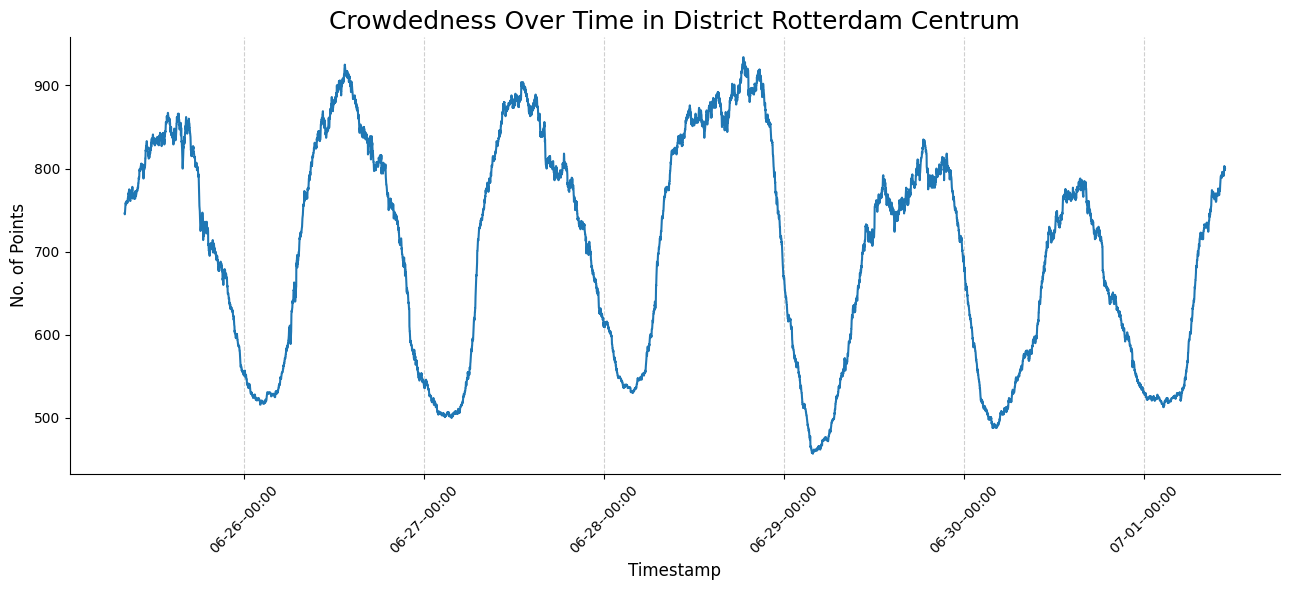

In [31]:
_, ax = plt.subplots(figsize=(13, 6))


ax.plot(
    pd.to_datetime(most_crowded_district["timestamp"], unit="s"),
    most_crowded_district["crowd"],
    linestyle="-",
    linewidth=1.5,
)

ax.set_title(
    f"Crowdedness Over Time in District {most_crowded_district_idx}", fontsize=18
)
ax.set_xlabel("Timestamp", fontsize=12)
ax.set_ylabel("No. of Points", fontsize=12)
plt.gca().spines[["top", "right"]].set_visible(False)
ax.grid(True, axis="x", linestyle="--", alpha=0.6)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d--%H:%M"))

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"figures/most_crowded_week_{n_files}.png", dpi=300)
plt.show()

In [32]:
most_crowded_district.to_parquet(
    f"data/processed/most_crowded_week_{n_files}.parquet", index=False
)

### Part 3 - Data Storage


In [42]:
weekly_data = [
    pd.read_parquet(f"data/processed/{week}")
    for week in os.listdir("data/processed")
    if week.startswith("points_")
]


pd.concat(weekly_data, ignore_index=True).to_parquet(
    "data/final/points_per_district_full.parquet.gzip", compression="gzip", index=False
)

#### Summary


In [33]:
min_t, max_t = pd.to_datetime(gdf["timestamp"].apply(["min", "max"]), unit="s").apply(
    lambda x: x.strftime("%d-%m-%Y--%H:%M")
)

In [35]:
print(f"Data is gathered between {min_t} and {max_t}")
print(f"Time between entries: {helper.REFRESH_INTERVAL} seconds")

Data is gathered between 25-06-2024--08:05 and 01-07-2024--10:51
Time between entries: 60 seconds
